# Introduction

It has been very difficult to know if the news published on social media in the last few years is true or false. In this analysis, we will determine whether any news on social media is true or false with a data set prepared from Twitter.

<font color = "blue">
Content:

1. [Load and Check Data](#1)
2. [Exploring Data](#2)
    * [Tweet Location](#3)
        - [In Test Data](#4)
        - [Label Encoding location column](#5)
    * [Keywords](#6)
        - [In Test Data](#7)
    * [Intersection](#8)
    * [Text Analysis](#9)
    
3. [Topic Modeling](#10)
    * [Latent Dirichlet Allocation (LDA)](#11)
    * [Part-of-Speech Tagging for questions](#12)

4. [Preprocessing](#13)
    * [Latent Semantic Analysis (LSA)](#14)
    * [Latent Dirichlet Allocation (LDA)](#15)
    
5. [Visualization of LDA](#16)
    * [Creating a transformation](#17)
    

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)
import os
import gc
gc.enable()
import time
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from scipy import stats
%matplotlib inline
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')
import urllib        #for url stuff

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast


from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands

import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE


from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

<a id = "1"></a>
# Load and Check Data

In [2]:
ROOT = '/kaggle/input/nlp-getting-started/'

## load the data 
df_train = pd.read_csv(ROOT+'train.csv')
df_test = pd.read_csv(ROOT+'test.csv')
df_sub = pd.read_csv(ROOT+'sample_submission.csv')

In [3]:
print(df_train.info())
print(df_test.info())
print(df_sub.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0  

In [4]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<a id = "2"></a>
# Exploring Data

* Checking target distrubution and class imbalance

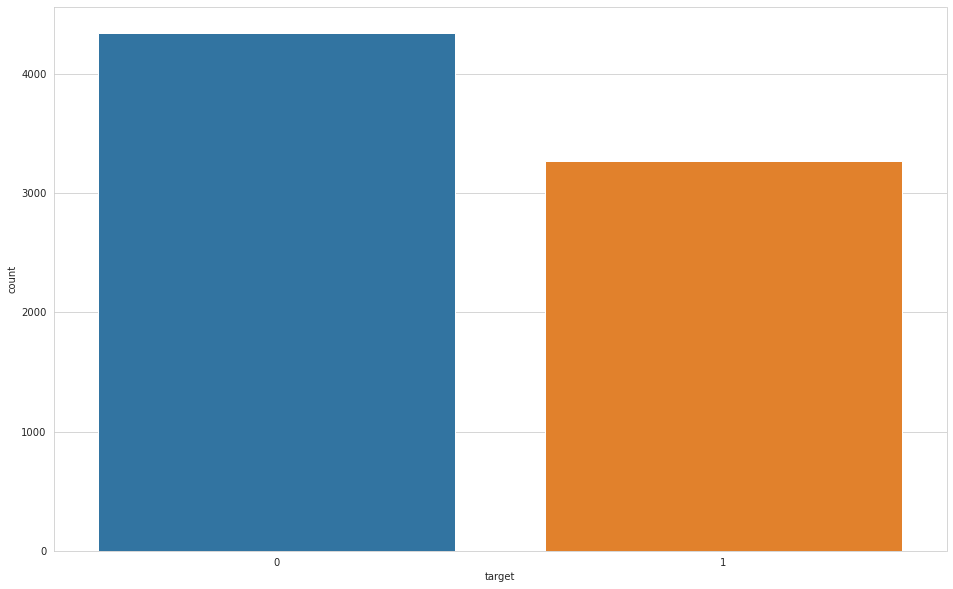

In [6]:
target = df_train['target']
sns.set_style('whitegrid')
sns.countplot(target)

In [7]:
df_train["text"].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [8]:
#To check the text content
df_train["text"].tolist()[:5]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']

In [9]:
t = df_train["text"].to_list()
for i in range(5):
    print('Tweet Number '+str(i+1)+': '+t[i])

Tweet Number 1: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tweet Number 2: Forest fire near La Ronge Sask. Canada
Tweet Number 3: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Tweet Number 4: 13,000 people receive #wildfires evacuation orders in California 
Tweet Number 5: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


<a id = "3"></a>
## Tweet Location

In [10]:
l = df_train["location"].to_list()
print('There is '+ str(len(set(l)))+" different loction")

There is 3342 different loction


In [11]:
#Posting Location top 20
df_train['location'].value_counts().head(n=20)

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
New York, NY        15
Everywhere          15
California, USA     15
United Kingdom      14
Name: location, dtype: int64

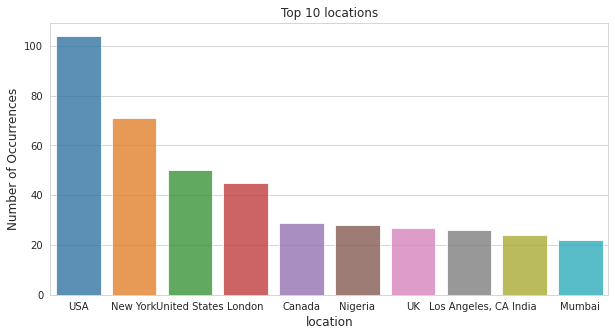

In [12]:
# Graph of the number of tweets in each location
location_count  = df_train['location'].value_counts()
location_count = location_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(location_count.index, location_count.values, alpha=0.8)
plt.title('Top 10 locations')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('location', fontsize=12)
plt.show()

<a id = "4"></a>
### In test data

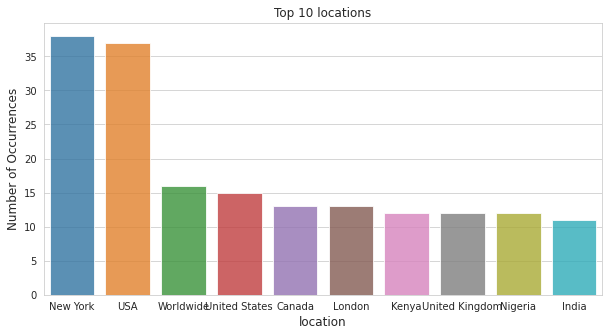

In [13]:
location_count  = df_test['location'].value_counts()
location_count = location_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(location_count.index, location_count.values, alpha=0.8)
plt.title('Top 10 locations')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('location', fontsize=12)
plt.show()

<a id = "5"></a>
### Label Encoding location column

In [14]:
df = df_train[df_train['location'].notnull()]

In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['location'] = le.fit_transform(df.location.values)

In [16]:
X = df['location']
y = df['target']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values.reshape(-1, 1))
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

T-SNE took 2.3e+01 s


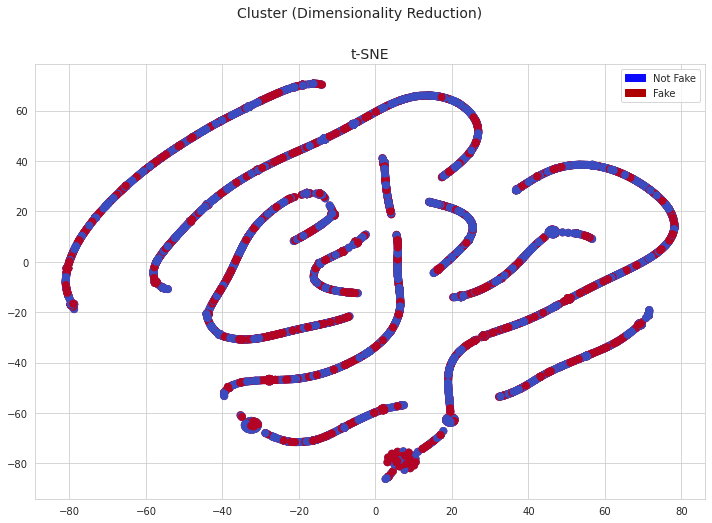

In [17]:
f, (ax1) = plt.subplots(1, 1, figsize=(12,8))

f.suptitle('Cluster (Dimensionality Reduction)', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='Not Fake')
red_patch = mpatches.Patch(color='#AF0000', label='Fake')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Not Fake', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fake', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


plt.show()

<a id = "6"></a>
## Keywords

In [18]:
df_train['keyword'].value_counts().head(n=20)

fatalities     45
armageddon     42
deluge         42
damage         41
harm           41
sinking        41
body%20bags    41
outbreak       40
windstorm      40
twister        40
siren          40
fear           40
collided       40
evacuate       40
collision      39
derailment     39
hellfire       39
wreckage       39
sinkhole       39
weapons        39
Name: keyword, dtype: int64

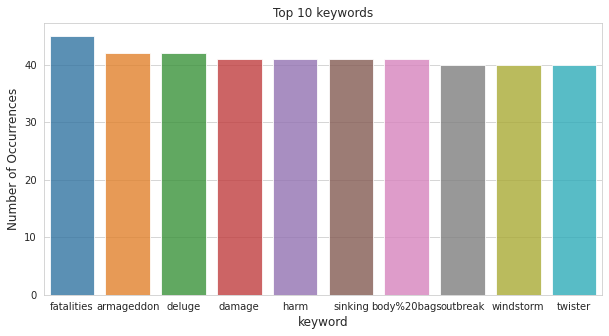

In [19]:
keyword_count  = df_train['keyword'].value_counts()
keyword_count = keyword_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(keyword_count.index, keyword_count.values, alpha=0.8)
plt.title('Top 10 keywords')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('keyword', fontsize=12)
plt.show()

<a id = "7"></a>
### In test data

In [20]:
df_test['keyword'].value_counts().head(n=20)

deluged               23
demolished            22
rubble                22
first%20responders    21
seismic               21
annihilation          21
snowstorm             21
obliteration          21
sirens                21
mayhem                20
catastrophic          20
survivors             20
avalanche             20
dead                  20
bioterrorism          20
obliterated           19
obliterate            19
hostage               19
suicide%20bomber      19
crushed               19
Name: keyword, dtype: int64

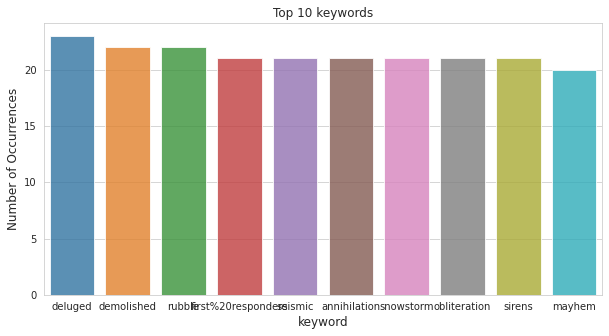

In [21]:
keyword_count  = df_test['keyword'].value_counts()
keyword_count = keyword_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(keyword_count.index, keyword_count.values, alpha=0.8)
plt.title('Top 10 keywords')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('keyword', fontsize=12)
plt.show()

* **There is a little difference between keywords in train and test set, I will check the intersection between the keywords in train and test**

In [22]:
keyword_train  = list(set(df_train['keyword']))
keyword_test  = list(set(df_test['keyword']))

print(len(keyword_train))
print(len(keyword_test))

222
222


<a id = "8"></a>
## Intersection

* **The intersection between the two datasets give us the same number of unique keywords, so the keywords used in both datasets with different occurrence**

In [23]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

len(intersection(keyword_train, keyword_test))

222

In [24]:
df = df_train[df_train['keyword'].notnull()]
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['keyword'] = le.fit_transform(df.keyword.values)

In [25]:
X = df['keyword']
y = df['target']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values.reshape(-1, 1))
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

T-SNE took 2.7e+01 s


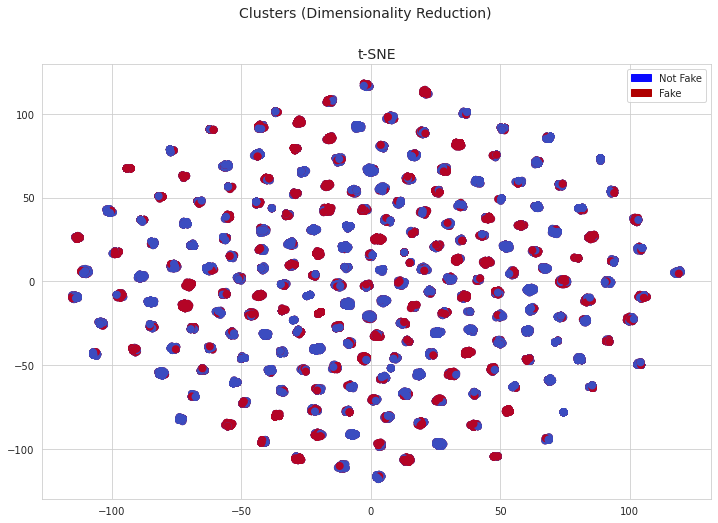

In [26]:
f, (ax1) = plt.subplots(1, 1, figsize=(12,8))
# labels = ['Not Fake', 'Fake']
f.suptitle('Clusters (Dimensionality Reduction)', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='Not Fake')
red_patch = mpatches.Patch(color='#AF0000', label='Fake')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Not Fake', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fake', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


plt.show()

* **Blue dots represent real events**

<a id = "9"></a>
## Text analysis

* I want to check if there is some duplicated tweets, it could be a retweet. If we know that a tweet is fake or not so the other duplicated tweets will get the same class.

In [27]:
len(set(df_train['text']))

7503

In [28]:
len(set(df_test['text']))

3243

<a id = "10"></a>
# Topic Modeling

* Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents.

* It's very important to do topic modeling and understand the content of each question and answer. The reason is that there is some question out of meaning and are not related to the category so they will get little answer and sometimes some blaming.

<a id = "11"></a>
## Latent Dirichlet Allocation (LDA)

In [29]:
html_tags = ['<P>', '</P>', '<Table>', '</Table>', '<Tr>', '</Tr>', '<Ul>', '<Ol>', '<Dl>', '</Ul>', '</Ol>', \
             '</Dl>', '<Li>', '<Dd>', '<Dt>', '</Li>', '</Dd>', '</Dt>']
r_buf = ['It', 'is', 'are', 'do', 'does', 'did', 'was', 'were', 'will', 'can', 'the', 'a', 'of', 'in', 'and', 'on', \
         'what', 'where', 'when', 'which'] + html_tags

def clean(x):
    x = x.lower()
    for r in r_buf:
        x = x.replace(r, '')
    x = re.sub(' +', ' ', x)
    return x

bin_question_tokens = ['it', 'is', 'are', 'do', 'does', 'did', 'was', 'were', 'will', 'can']
stop_words = text.ENGLISH_STOP_WORDS.union(["book"])

def predict(json_data, annotated=False):
    # Parse JSON data
    candidates = json_data['long_answer_candidates']
    candidates = [c for c in candidates if c['top_level'] == True]
    doc_tokenized = json_data['document_text'].split(' ')
    question = json_data['question_text']
    question_s = question.split(' ') 
    if annotated:
        ann = json_data['annotations'][0]

    tfidf = TfidfVectorizer(ngram_range=(1,1), stop_words=stop_words)
    tfidf.fit([json_data['document_text']])
    q_tfidf = tfidf.transform([question]).todense()

    # Find the nearest answer from candidates
    distances = []
    scores = []
    i_ann = -1
    for i, c in enumerate(candidates):
        s, e = c['start_token'], c['end_token']
        t = ' '.join(doc_tokenized[s:e])
        distances.append(levenshtein_distance(clean(question), clean(t)))
        
        t_tfidf = tfidf.transform([t]).todense()
        score = 1 - spatial.distance.cosine(q_tfidf, t_tfidf)
        
        scores.append(score)

    # Format results
    
    ans = candidates[np.argmax(scores)]
    if np.max(scores) < 0.2:
        ans_long = '-1:-1'
    else:
        ans_long = str(ans['start_token']) + ':' + str(ans['end_token'])
    if question_s[0] in bin_question_tokens:
        ans_short = 'YES'
    else:
        ans_short = ''
        
    # Preparing data for debug
    if annotated:
        ann_long_text = ' '.join(doc_tokenized[ann['long_answer']['start_token']:ann['long_answer']['end_token']])
        if ann['yes_no_answer'] == 'NONE':
            if len(json_data['annotations'][0]['short_answers']) > 0:
                ann_short_text = ' '.join(doc_tokenized[ann['short_answers'][0]['start_token']:ann['short_answers'][0]['end_token']])
            else:
                ann_short_text = ''
        else:
            ann_short_text = ann['yes_no_answer']
    else:
        ann_long_text = ''
        ann_short_text = ''
        
    ans_long_text = ' '.join(doc_tokenized[ans['start_token']:ans['end_token']])
    if len(ans_short) > 0 or ans_short == 'YES':
        ans_short_text = ans_short
    else:
        ans_short_text = '' # Fix when short answers will work
                    
    return ans_long, ans_short, question, ann_long_text, ann_short_text, ans_long_text, ans_short

In [30]:
reindexed_data = df_train['text'] 

In [31]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii',errors="ignore").decode('utf-8',errors="ignore") for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

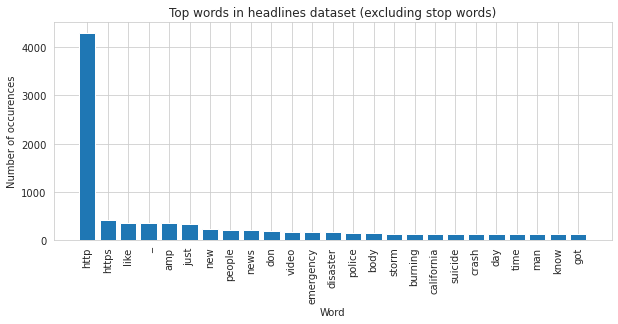

In [32]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=25,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

* Next, we create a histogram of the headline word lengths and use speech fragment tagging to understand the types of words used in the entire community. This requires first converting all header strings to TextBlobs and calling the pos_tags method for each, giving a list of tagged words for each header.

In [33]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [34]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per tweet: ', np.mean(word_counts))

Total number of words:  122690
Mean number of words per tweet:  16.11585445947721


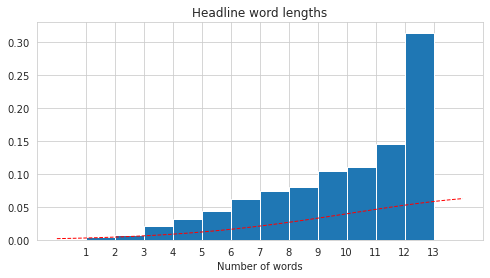

In [35]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

<a id = "12"></a>
## Part-of-Speech Tagging for questions

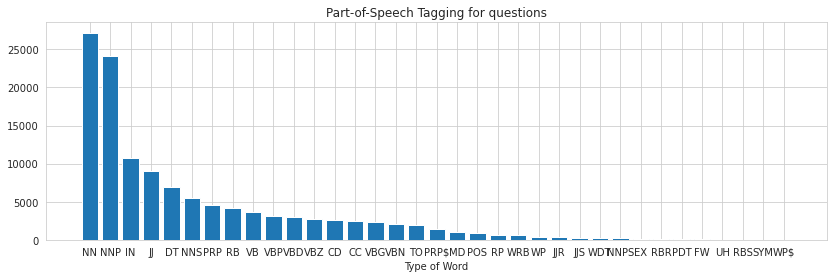

In [36]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(14,4))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for questions');
ax.set_xlabel('Type of Word');

<a id = "13"></a>
# Preprocessing

* Now I'll apply a clustering algorithm to headlines to examine the topic and how it has evolved over time.

* The only preprocessing step required in our case is feature construction. In practice, this simply means converting each string to a numerical vector.

In [37]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=500, random_state=0).values

print('Tweets before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Tweets after vectorization: \n{}'.format(small_document_term_matrix[123]))

Tweets before vectorization: NowPlaying Rock You Like A Hurricane - Scorpions http://t.co/JRztpT8IJq
Tweets after vectorization: 
  (0, 1315)	1
  (0, 1564)	1
  (0, 1328)	1
  (0, 2263)	1
  (0, 1841)	1
  (0, 2339)	1
  (0, 1447)	1


* Thus we have training data, small_document_term_matrix and we can implement a clustering algorithm.
* Our choice will be either Latent Semantic Analysis (LSA) or Latent Dirichlet Allocation (LDA). 

In [38]:
n_topics = 5

<a id = "14"></a>
## Latent Semantic Analysis (LSA)

* This is effectively just a truncated singular value decomposition of a document-term matrix, with only the r= n_topics largest singular values preserved.

In [39]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [40]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [41]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [42]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii',errors="ignore").decode('utf-8',errors="ignore"))
        top_words.append(" ".join(topic_words))         
    return top_words

In [43]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  http _ new news police storm people set video wildfire
Topic 2:  like https amp don man body day _ year think
Topic 3:  people saudi suicide mosque bomber http want time kills news
Topic 4:  just twitter love got ll armageddon im great going exploded
Topic 5:  al zabadani replace birmingham ahrar dee silver twister tower clutch


* We've turned our first small title example into a list of predicted subject categories, where each category is characterized by the most common words.

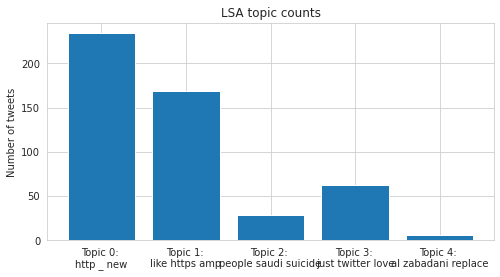

In [44]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of tweets');
ax.set_title('LSA topic counts');
plt.show()

* To accurately compare LSA with LDA, we use a size reduction technique called t-SNE that will serve to better illuminate the success of the clustering process.

In [45]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.049480
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.493355
[t-SNE] KL divergence after 2000 iterations: 0.243077


In [46]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [47]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

* Now we have reduced these n_topics-dimensional vectors to two-dimensional representations, we can plot the clusters using Bokeh. 

In [48]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

* This is a bit a of a failed result.
* Let's move forward and try another clustering method.

<a id = "15"></a>
## Latent Dirichlet Allocation (LDA)

* We'll repeat same process using LDA.

In [49]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [50]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [51]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  http police just accident https world car black killed avalanche
Topic 2:  http news _ new suicide saudi set mosque life bomber
Topic 3:  http https people like amp disaster want storm look rt
Topic 4:  http like amp airplane accident man emergency drought fires _
Topic 5:  http just don love got new like day fatalities burned


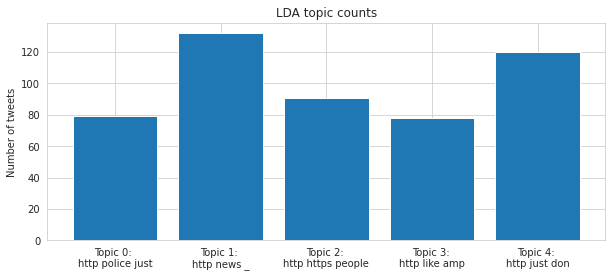

In [52]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of tweets');

* We project this matrix in two dimensions so that we can compare LDA and LSA accurately.

In [53]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.015812
[t-SNE] KL divergence after 250 iterations with early exaggeration: 38.557270
[t-SNE] KL divergence after 1250 iterations: 0.041864


In [54]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=600, plot_height=600)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

* This is a much better result.
*  For this reason, LDA appears the more appropriate algorithm when we scale up the clustering process.

<a id = "16"></a>
# Visualization of LDA

In [55]:
# Preparing a corpus for analysis and checking the first 5 entries
corpus=[]

corpus = df_train['text'].to_list()

corpus[:5]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']

In [56]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [57]:
# removing common words and tokenizing
# google-quest-challenge
stoplist = stopwords.words('english') + list(punctuation) + list("([)]?") + [")?"]

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'tweets.dict'))  # store the dictionary

In [58]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'tweets.mm'), corpus) 

* We created a corpus of documents represented as a stream of vectors.
* To continue, lets use that corpus, with the help of Gensim.

*Gensim is an open-source library for unsupervised topic modeling and natural language processing, using modern statistical machine learning. Gensim is implemented in Python and Cython. (WIKIPEDIA)* 

<a id = "17"></a>
## Creating a transformation

* The transformations are standard Python objects, typically initialized by means of a training corpus

* Different transformations may require different initialization parameters; in case of TfIdf, the “training” consists simply of going through the supplied corpus once and computing document frequencies of all its features. Training other models, such as LST OR LDA.

In [59]:
tfidf = models.TfidfModel(corpus) # initialize a model

In [60]:
corpus_tfidf = tfidf[corpus]  # use the model to transform vectors

* LDA’s topics can be interpreted as probability distributions over words.
* So i'll try 10 topics.

In [61]:
total_topics = 10

lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]

In [62]:
# Show first n important word in the topics

lda.show_topics(total_topics,5)

[(0,
  '0.022*"suicide" + 0.012*"thunder" + 0.011*"failure" + 0.009*"trauma" + 0.009*"typhoon"'),
 (1,
  '0.010*"traumatised" + 0.008*"still" + 0.008*"watch" + 0.007*"suicide" + 0.007*"military"'),
 (2,
  '0.020*"storm" + 0.013*"trapped" + 0.012*"saudi" + 0.010*"mosque" + 0.010*"officer"'),
 (3,
  '0.016*"families" + 0.011*"mh370:" + 0.010*"weapons" + 0.010*"malaysia" + 0.008*"oil"'),
 (4,
  '0.012*"violent" + 0.011*"survivors" + 0.009*"volcano" + 0.007*"wildfire" + 0.006*"news"'),
 (5, '0.008*"water" + 0.007*"3" + 0.006*"pic" + 0.006*"time" + 0.006*"heat"'),
 (6,
  '0.010*"pkk" + 0.009*"video" + 0.009*"train" + 0.008*"tornado" + 0.008*"bomb"'),
 (7,
  '0.014*"wounded" + 0.013*"obama" + 0.011*"police" + 0.010*"disaster" + 0.010*"terrorist"'),
 (8,
  '0.011*"get" + 0.007*"i\'m" + 0.007*"??" + 0.006*"one" + 0.006*"northern"'),
 (9,
  '0.022*"like" + 0.013*"i\'m" + 0.011*"&amp;" + 0.010*"released" + 0.010*"sinking"')]

In [63]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}

In [64]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(10, 217)


In [65]:
df_lda

,suicide,thunder,failure,trauma,typhoon,#news,killed,severe,security,people,weather,hollywood,new,zone,mass,california,county,august,summer,site,??,bus,policy,wildfire,there's,...,minute,home,last,car,lost,maybe,released,sinking,thunderstorm,survive,warning,without,back,wild,can't,would,looks,everyone,think,going,make,send,live,coaches,another
0,0.021569,0.011839,0.01059,0.008965,0.008629,0.008215,0.007993,0.007680,0.007064,0.007026,0.006919,0.006899,0.006569,0.00545,0.005282,0.004888,0.004819,0.004776,0.004584,0.004536,0.004514,0.004274,0.004237,0.004115,0.004077,...,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.007446,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.004952,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.006223,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007873,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006519,0.000000,...,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.00000,0.000000,0.000000,0.003581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.005237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003865,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000

In [66]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      32.420952   8.115230       1        1  36.075277
7       0.648955  71.707100       2        1  12.516063
6      71.019684   9.971006       3        1  12.387365
5       3.785981  33.185135       4        1   8.596917
8     -42.666500  -9.222070       5        1   5.076636
2      -3.621689 -43.526516       6        1   5.070248
0      -3.632402  -4.171708       7        1   5.069554
1     -36.584400  35.804413       8        1   5.069535
9      44.391380  50.615383       9        1   5.069518
3      40.235809 -31.591665      10        1   5.068886, topic_info=           Term       Freq      Total Category  logprob  loglift
2150    violent  33.000000  33.000000  Default  30.0000  30.0000
1388  survivors  29.000000  29.000000  Default  29.0000  29.0000
2482    suicide  13.000000  13.000000  Default  28.0000  28.0000
140        like  27.000000  27.000000  Default  27.0000  27.0000
5593    wounded  13.000000  13.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
5834   disaster   2.423944  13.968677  Topic10  -5.0702   1.2306
760        many   1.823725   5.738308  Topic10  -5.3547   1.8358
140        like   2.523840  27.216825  Topic10  -5.0298   0.6040
914         via   1.701696  19.613104  Topic10  -5.4239   0.5375
275         man   1.544768   6.368676  Topic10  -5.5207   1.5655

[590 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
4534       4  1.081490          #??
10112     10  0.726215         #???
9141       1  0.936543         #art
12383      1  1.038569         #cnn
0          1  1.003340  #earthquake
...      ...       ...          ...
283        8  0.486005        years
283        9  0.243002        years
9553       7  0.903933         zone
1565       9  1.592459        zone.
201        3  0.906731          ûó

[793 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 7, 6, 9, 3, 1, 2, 10, 4])